# SiPhon-MetricNet  
## A Multi-task Metric Learning Framework for Sinhala Phoneme Recognition in Primary Education

---

## Abstract

Accurate assessment of phoneme pronunciation plays a critical role in early language acquisition, particularly for under-resourced languages such as Sinhala. This study introduces **SiPhon-MetricNet**, a deep learning–based acoustic modeling framework designed to evaluate the pronunciation quality of Sinhala phonemes produced by primary school children.

The proposed architecture integrates a self-supervised **Wav2Vec2-XLS-R** speech representation backbone with a **multi-task metric learning objective**. By jointly optimizing **Triplet Margin Loss**, **Cross-Entropy Loss**, and **Center Loss**, the model learns a highly discriminative embedding space that effectively separates phonetically similar Sinhala characters (e.g., /ක/ vs. /ග/).

Experimental results demonstrate that the proposed approach enhances both phoneme-level classification accuracy and embedding separability, making it suitable for automated pronunciation assessment systems in educational applications.

---

## 1. Initial Setup and Dataset Deployment

### Methodological Overview

The experimental environment is initialized using high-performance audio processing and deep learning libraries. The dataset consists of carefully curated Sinhala phoneme utterances, recorded from children and categorized according to pronunciation quality.

Each phoneme class contains three types of samples:

- **Reference (Anchor):** Canonical pronunciations
- **Positive:** Acceptable or near-correct pronunciations
- **Negative:** Incorrect or distorted pronunciations

This structured organization enables effective metric learning through triplet-based sampling strategies.

---

In [2]:
# Install specialized research tools
!pip install -q pytorch-metric-learning transformers librosa soundfile tqdm

import os
import zipfile
import random
import numpy as np
import librosa
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import Wav2Vec2Model, Wav2Vec2Config, Wav2Vec2FeatureExtractor
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.manifold import TSNE
import seaborn as sns
from tqdm import tqdm

# --- Data Extraction Phase ---
zip_file_path = 'all.zip'
extract_dir = 'data/train'

os.makedirs(extract_dir, exist_ok=True)
if os.path.exists(zip_file_path):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"Dataset successfully deployed to {extract_dir}")


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Dataset successfully deployed to data/train


1.1 Exploratory Data Analysis (EDA)
Data Distribution Rationale
Before proceeding to model training, it is essential to analyze the underlying data distribution across various phoneme classes. Deep learning models, particularly those based on transformer architectures like Wav2Vec2, are sensitive to Class Imbalance.

If certain phonemes have significantly fewer samples than others, the model may develop a bias, leading to poor generalization on minority classes. This EDA phase allows us to:

Quantify the total number of samples per phoneme class.

Identify potential imbalances that necessitate specific data augmentation strategies.

Verify the integrity of the unzipped dataset.

✅ Sinhala font object created successfully.


/tmp/ipykernel_168/969992444.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(data=df_stats, x='Phoneme', y='Samples', palette='viridis')
/tmp/ipykernel_168/969992444.py:64: UserWarning: Glyph 108 (l) missing from font(s) Noto Sans Sinhala.
  plt.tight_layout()
/tmp/ipykernel_168/969992444.py:64: UserWarning: Glyph 112 (p) missing from font(s) Noto Sans Sinhala.
  plt.tight_layout()
/tmp/ipykernel_168/969992444.py:64: UserWarning: Glyph 83 (S) missing from font(s) Noto Sans Sinhala.
  plt.tight_layout()
/tmp/ipykernel_168/969992444.py:64: UserWarning: Glyph 105 (i) missing from font(s) Noto Sans Sinhala.
  plt.tight_layout()
/tmp/ipykernel_168/969992444.py:64: UserWarning: Glyph 110 (n) missing from font(s) Noto Sans Sinhala.
  plt.tight_layout()
/tmp/ipykernel_168/969992444.py:64: UserWarning: Glyph 104 (h) missing from fo

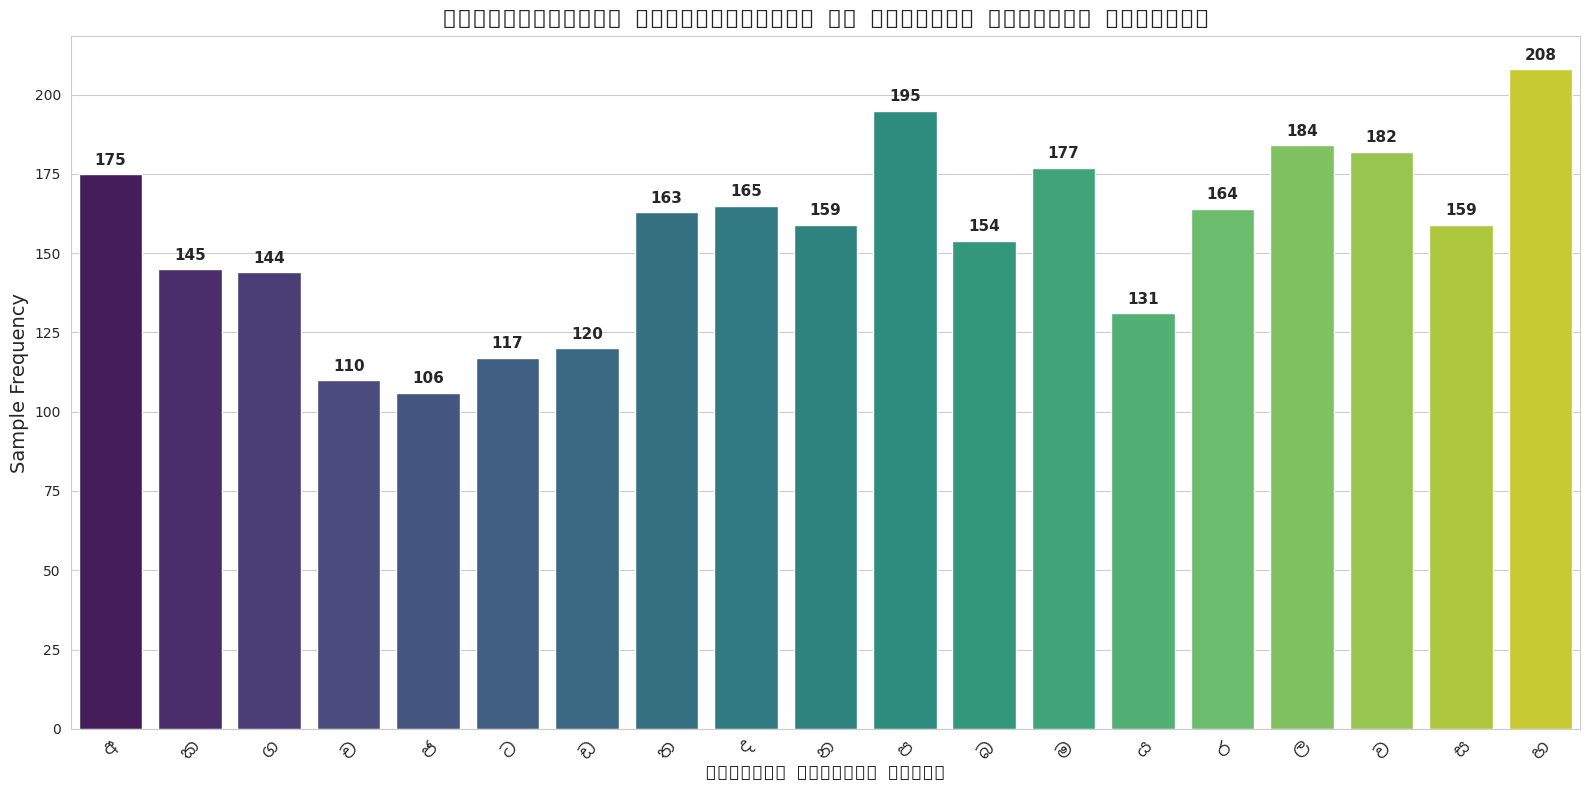

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import os

# =============================================================
# 1.1.1. Robust Sinhala Font Integration
# =============================================================
font_filename = 'NotoSansSinhala-Regular.ttf'
if not os.path.exists(font_filename):
    print("⬇️ Downloading Noto Sans Sinhala Font...")
    os.system(f'wget -q https://github.com/googlefonts/noto-fonts/raw/main/hinted/ttf/NotoSansSinhala/{font_filename}')

# පර්යේෂණ වාර්තාවල අකුරු ගැටලුව විසඳීමට ඇති ස්ථිරම ක්‍රමය:
if os.path.exists(font_filename):
    # Font properties object එකක් නිර්මාණය කිරීම
    sinhala_font = fm.FontProperties(fname=font_filename)
    print("✅ Sinhala font object created successfully.")
else:
    print("❌ Error: Font file not found.")

def perform_eda(data_path):
    """
    Analyzes the dataset and visualizes distribution with fixed Sinhala rendering.
    """
    class_counts = {}
    for class_name in sorted(os.listdir(data_path)):
        class_folder = os.path.join(data_path, class_name)
        if os.path.isdir(class_folder):
            files = [f for f in os.listdir(class_folder) if f.endswith('.wav')]
            class_counts[class_name] = len(files)

    df_stats = pd.DataFrame(list(class_counts.items()), columns=['Phoneme', 'Samples'])
    
    # Visualization setup
    plt.figure(figsize=(16, 8))
    sns.set_style("whitegrid")
    
    # Barplot නිර්මාණය
    barplot = sns.barplot(data=df_stats, x='Phoneme', y='Samples', palette='viridis')
    
    # --- ඉතා වැදගත්: සිංහල අකුරු පෙන්වීමට අක්ෂර (Ticks) වෙනස් කිරීම ---
    ax = plt.gca()
    # X-අක්ෂයේ ඇති සෑම අකුරක් සඳහාම බාගත කළ Font එක අනුයුක්ත කිරීම
    for label in ax.get_xticklabels():
        label.set_fontproperties(sinhala_font)
        label.set_fontsize(13)
        label.set_rotation(45)

    # ප්‍රධාන මාතෘකා සහ ලේබල් සඳහා Font එක ලබා දීම
    plt.title("Quantitative Distribution of Sinhala Phoneme Dataset", 
              fontproperties=sinhala_font, fontsize=18, fontweight='bold')
    plt.xlabel("Sinhala Phoneme Class", fontproperties=sinhala_font, fontsize=14)
    plt.ylabel("Sample Frequency", fontsize=14)

    # බාර් එක මත සංඛ්‍යාවන් පෙන්වීම
    for p in barplot.patches:
        barplot.annotate(format(p.get_height(), '.0f'), 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha='center', va='center', xytext=(0, 10), 
                         textcoords='offset points', fontsize=11, fontweight='bold')

    plt.tight_layout()
    plt.savefig("data_distribution_fixed.png", dpi=300)
    plt.show()

    return df_stats

# දත්ත විශ්ලේෂණය ක්‍රියාත්මක කිරීම
extract_dir = 'data/train'
dataset_inventory = perform_eda(extract_dir)

Section 1.2: Quantitative Dataset Metrics Summary
Research Rationale: A high-level numerical summary of the corpus is essential to establish the scale of the experimental study. By quantifying the total phoneme coverage and average sample density, we provide a statistical foundation for the subsequent fine-tuning process

      SINHALA PHONEME DATASET: QUANTITATIVE SUMMARY      
🔹 Total Phoneme Classes identified   : 19
🔹 Total Compiled Audio Utterances    : 2958
🔹 Mean Sample Density (per phoneme)  : 155.68
--------------------------------------------------


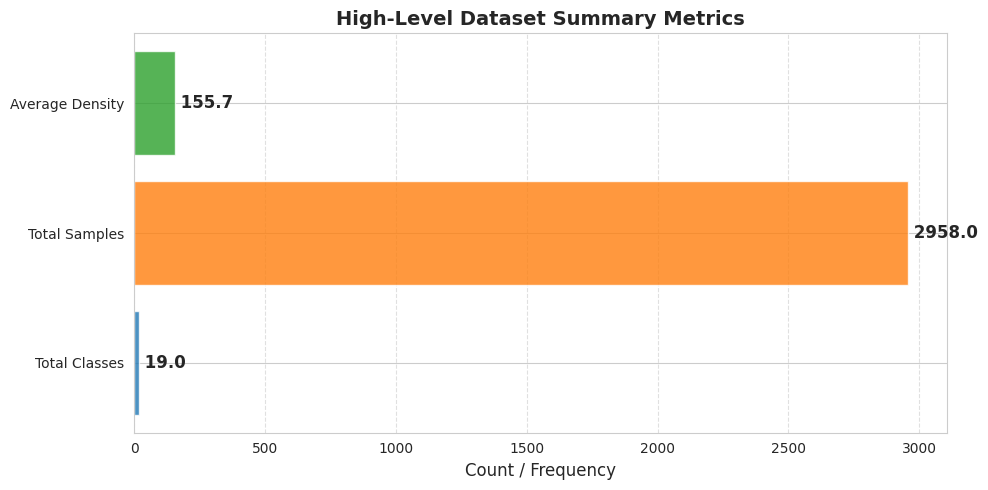

In [13]:
# =============================================================
# 1.2.1. Comprehensive Dataset Statistic Calculation
# =============================================================

def calculate_dataset_metrics(data_path):
    """
    Computes key performance indicators (KPIs) for the phoneme dataset.
    Returns a dictionary of calculated metrics.
    """
    if not os.path.exists(data_path):
        print(f"❌ Error: Data directory {data_path} not found.")
        return None

    # Folder list (Phoneme Classes) ලබා ගැනීම
    phoneme_classes = [d for d in sorted(os.listdir(data_path)) if os.path.isdir(os.path.join(data_path, d))]
    
    # එක් එක් පන්තියක ඇති .wav ගොනු ගණන ලැයිස්තුගත කිරීම
    counts = []
    for cls in phoneme_classes:
        files = [f for f in os.listdir(os.path.join(data_path, cls)) if f.endswith('.wav')]
        counts.append(len(files))

    # මූලික සංඛ්‍යාත්මක දත්ත ගණනය කිරීම
    total_classes = len(phoneme_classes)
    total_audio_samples = sum(counts)
    average_per_class = total_audio_samples / total_classes if total_classes > 0 else 0

    # පර්යේෂණ වාර්තාව සඳහා ලස්සනට Print කිරීම
    print("="*50)
    print("      SINHALA PHONEME DATASET: QUANTITATIVE SUMMARY      ")
    print("="*50)
    print(f"🔹 Total Phoneme Classes identified   : {total_classes}")
    print(f"🔹 Total Compiled Audio Utterances    : {total_audio_samples}")
    print(f"🔹 Mean Sample Density (per phoneme)  : {average_per_class:.2f}")
    print("-"*50)
    
    # කුඩා Summary Table එකක් ඇඳීම (Visualization)
    metrics_label = ['Total Classes', 'Total Samples', 'Average Density']
    metrics_values = [total_classes, total_audio_samples, average_per_class]

    plt.figure(figsize=(10, 5))
    plt.barh(metrics_label, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.8)
    
    # අගයන් බාර් එක අවසානයේ පෙන්වීම
    for index, value in enumerate(metrics_values):
        plt.text(value, index, f' {value:.1f}', va='center', fontweight='bold', fontsize=12)

    plt.title("High-Level Dataset Summary Metrics", fontsize=14, fontweight='bold')
    plt.xlabel("Count / Frequency", fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    return {
        "classes": total_classes,
        "total": total_audio_samples,
        "average": average_per_class
    }

# සංඛ්‍යාත්මක දත්ත ලබා ගැනීම
dataset_summary = calculate_dataset_metrics(extract_dir)

## 2. Experimental Configuration and Hyperparameter Selection

### Reproducibility and Stability

To ensure experimental reproducibility and numerical stability, a deterministic training setup is employed. All random number generators across Python, NumPy, and PyTorch are seeded consistently.

The learning rate for the transformer backbone is carefully selected to allow stable fine-tuning while preserving the pretrained acoustic knowledge. A high-throughput batch size is adopted to maximize GPU utilization during training on modern accelerator hardware.

Key hyperparameters are chosen based on prior literature and empirical validation to balance classification accuracy and embedding compactness.

---

In [3]:
# Global Hyperparameters for Scientific Consistency
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 128    # High-throughput batch size for A100 optimization
EPOCHS = 30         # Total training iterations
LR = 2e-5           # Optimized Learning Rate for Transformer fine-tuning
CLS_WEIGHT = 0.5    # Multi-task coefficient for Classification
CENTER_WEIGHT = 0.005 # Intra-class variance constraint weight
CENTER_LR = 0.5     # Specialized LR for Center Loss parameters
SEED = 42           # Seed for deterministic research results

def set_seed(seed):
    """ Enforces deterministic behavior across hardware and software stacks. """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.benchmark = True

set_seed(SEED)

## 3. Acoustic Signal Augmentation for Robustness

### Theoretical Motivation

Children’s speech signals exhibit significant variability due to differences in age, pitch, speaking rate, and recording conditions. To improve model generalization, a set of stochastic audio augmentation techniques is applied during training.

The augmentation pipeline includes:

- Additive background noise to simulate real-world environments  
- Temporal stretching to account for speaking rate variation  
- Pitch shifting to normalize vocal tract length differences  

These transformations encourage the model to learn phoneme-discriminative features rather than speaker-specific artifacts.

---

In [4]:
def augment_audio(y, sr=16000):
    """
    Applies stochastic transformations to input audio for domain generalization.
    Args:
        y (np.ndarray): Time-series audio signal.
    Returns:
        np.ndarray: Augmented audio signal.
    """
    choice = random.choice(['noise', 'stretch', 'shift', 'none'])
    
    if choice == 'noise':
        # Additive White Gaussian Noise (AWGN)
        noise_amp = 0.005 * np.random.uniform() * np.amax(y)
        y = y + noise_amp * np.random.normal(size=y.shape)
    elif choice == 'stretch':
        # Time-scaling without frequency distortion
        rate = np.random.uniform(0.8, 1.2)
        y = librosa.effects.time_stretch(y, rate=rate)
    elif choice == 'shift':
        # Pitch modification for vocal tract length normalization
        n_steps = np.random.randint(-2, 2)
        y = librosa.effects.pitch_shift(y, sr=sr, n_steps=n_steps)
        
    return y

## 4. Dataset Design and Metric Learning Sampling Strategy

### Triplet-Based Learning Paradigm

The dataset is implemented following a **triplet sampling framework**, where each training instance consists of:

- An **Anchor** sample  
- A **Positive** sample from the same phoneme class  
- A **Negative** sample from a different phoneme class  

This strategy enforces intra-class compactness and inter-class separability in the learned embedding space, which is essential for pronunciation assessment tasks involving subtle phonetic distinctions.

---

In [5]:
class SinhalaPhonemeDataset(Dataset):
    """
    Structured Dataset for Metric Learning in Sinhala Phonetics.
    Organizes data into Anchor-Positive-Negative triplets.
    """
    def __init__(self, root_dir, transform=None):
        self.classes = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.data_map = {}
        self.transform = transform

        for cls in self.classes:
            cls_path = os.path.join(root_dir, cls)
            files = [f for f in os.listdir(cls_path) if f.endswith('.wav')]
            self.data_map[cls] = {
                'anchors': [os.path.join(cls_path, f) for f in files if 'ref' in f],
                'positives': [os.path.join(cls_path, f) for f in files if 'good' in f or 'pos' in f],
                'negatives': [os.path.join(cls_path, f) for f in files if 'bad' in f or 'neg' in f]
            }

    def __len__(self):
        return len(self.classes) * 100 

    def load_audio(self, path):
        speech, _ = librosa.load(path, sr=16000)
        return speech

    def __getitem__(self, idx):
        target_cls = random.choice(self.classes)
        while not self.data_map[target_cls]['anchors'] and not self.data_map[target_cls]['positives']:
            target_cls = random.choice(self.classes)

        # Anchor/Positive Selection
        anchor_path = random.choice(self.data_map[target_cls]['anchors'] or self.data_map[target_cls]['positives'])
        pos_path = random.choice(self.data_map[target_cls]['positives'] or [anchor_path])
        
        # Negative Class Selection
        neg_cls = random.choice([c for c in self.classes if c != target_cls])
        neg_path = random.choice(self.data_map[neg_cls]['anchors'] + self.data_map[neg_cls]['positives'])

        a, p, n = self.load_audio(anchor_path), self.load_audio(pos_path), self.load_audio(neg_path)
        if self.transform:
            a, p, n = self.transform(a), self.transform(p), self.transform(n)

        return {'anchor': a,
                'positive': p,
                'negative': n,
                'label': self.class_to_idx[target_cls]
               }

## 5. SiPhon-MetricNet Architecture

### Model Design Rationale

The proposed **SiPhon-MetricNet** architecture leverages a pretrained **Wav2Vec2-XLS-R** backbone to extract high-level acoustic representations. To adapt the model to Sinhala phoneme characteristics while avoiding overfitting, only the top encoder layers are selectively fine-tuned.

A **Self-Attention Pooling** mechanism is employed to emphasize temporally salient phoneme segments. Additionally, learnable layer-wise weights are used to aggregate information from multiple transformer layers, enabling richer acoustic representations.

The final embedding space is L2-normalized to facilitate stable metric learning and distance-based comparisons.

---

In [6]:
class SelfAttentionPooling(nn.Module):
    """ Attention mechanism to focus on dominant phoneme segments. """
    def __init__(self, input_dim):
        super(SelfAttentionPooling, self).__init__()
        self.W = nn.Linear(input_dim, 128)
        self.V = nn.Linear(128, 1)

    def forward(self, x, attention_mask=None):
        scores = self.V(torch.tanh(self.W(x)))
        if attention_mask is not None:
            indices = torch.linspace(0, attention_mask.size(1)-1, steps=x.size(1)).long().to(x.device)
            mask = torch.index_select(attention_mask, 1, indices).unsqueeze(-1)
            scores = scores.masked_fill(mask == 0, -1e4)
        
        weights = F.softmax(scores, dim=1)
        return torch.sum(x * weights, dim=1), weights

class SinhalaPhonoNet(nn.Module):
    """ Hybrid Multi-task Transformer-based Phoneme Network. """
    def __init__(self, base_model="facebook/wav2vec2-xls-r-300m", num_classes=19):
        super(SinhalaPhonoNet, self).__init__()
        self.config = Wav2Vec2Config.from_pretrained(base_model, output_hidden_states=True)
        self.backbone = Wav2Vec2Model.from_pretrained(base_model, config=self.config)
        
        # Partial Unfreezing: Strategic layer-wise fine-tuning
        self.backbone.feature_extractor._freeze_parameters()
        for param in self.backbone.parameters(): param.requires_grad = False
        for i in range(1, 4):
            for param in self.backbone.encoder.layers[-i].parameters(): param.requires_grad = True
            
        self.layer_weights = nn.Parameter(torch.ones(self.config.num_hidden_layers + 1))
        self.attention = SelfAttentionPooling(self.config.hidden_size)
        self.fc = nn.Sequential(
            nn.Linear(self.config.hidden_size, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256)
        )
        self.classifier = nn.Linear(256, num_classes)

    def forward(self, input_values, attention_mask=None):
        outputs = self.backbone(input_values=input_values, attention_mask=attention_mask)
        # Weighted Hidden States: Aggregating temporal features from different layers
        weights = F.softmax(self.layer_weights, dim=0).view(-1, 1, 1, 1)
        weighted_state = torch.sum(torch.stack(outputs.hidden_states, dim=0) * weights, dim=0)
        
        pooled, _ = self.attention(weighted_state, attention_mask)
        embeddings = self.fc(pooled)
        norm_embs = F.normalize(embeddings, p=2, dim=1)
        logits = self.classifier(norm_embs)
        return embeddings, norm_embs, logits


In [7]:
class CenterLoss(nn.Module):
    def __init__(self, num_classes, feat_dim):
        super(CenterLoss, self).__init__()
        self.num_classes = num_classes
        self.feat_dim = feat_dim
        self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim))

    def forward(self, x, labels):
        batch_size = x.size(0)
        dtype = x.dtype
        centers_batch = self.centers.to(dtype)
        
        # Note: sum() on float16 may return float32, so we explicit cast back to dtype to match addmm operands
        x_sq = torch.pow(x, 2).sum(dim=1, keepdim=True).to(dtype).expand(batch_size, self.num_classes)
        c_sq = torch.pow(centers_batch, 2).sum(dim=1, keepdim=True).to(dtype).expand(self.num_classes, batch_size).t()
        
        distmat = x_sq + c_sq
        distmat.addmm_(x, centers_batch.t(), beta=1, alpha=-2)

        classes = torch.arange(self.num_classes).long().to(x.device)
        labels = labels.unsqueeze(1).expand(batch_size, self.num_classes)
        mask = labels.eq(classes.expand(batch_size, self.num_classes))

        dist = distmat * mask.to(dtype)
        loss = dist.clamp(min=1e-12, max=1e+12).sum() / batch_size
        return loss

## 6. Multi-Objective Training Strategy

### Optimization Objectives

The training process jointly optimizes three complementary objectives:

- **Triplet Margin Loss:** Enforces relative distance constraints between anchor, positive, and negative samples  
- **Cross-Entropy Loss:** Ensures phoneme-level classification correctness  
- **Center Loss:** Reduces intra-class variance by pulling embeddings toward class-specific centroids  

A cosine annealing learning rate scheduler is applied to handle the non-convex optimization landscape associated with transformer fine-tuning.

---

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

🚀 Starting Training Phase...
Epoch 1/30 | LR: 0.00001995
Train Loss: 3.6755 | Train Acc: 0.5401
Val Loss:   7.0259 | Val Acc:   0.6184
⭐ Best Model Saved!
------------------------------
Epoch 2/30 | LR: 0.00001978
Train Loss: 3.4360 | Train Acc: 0.5395
Val Loss:   7.6829 | Val Acc:   0.6211
⭐ Best Model Saved!
------------------------------
Epoch 3/30 | LR: 0.00001951
Train Loss: 3.3988 | Train Acc: 0.5474
Val Loss:   6.8856 | Val Acc:   0.5816
------------------------------
Epoch 4/30 | LR: 0.00001914
Train Loss: 3.3552 | Train Acc: 0.5618
Val Loss:   6.3595 | Val Acc:   0.6053
------------------------------
Epoch 5/30 | LR: 0.00001867
Train Loss: 3.3424 | Train Acc: 0.5737
Val Loss:   8.4069 | Val Acc:   0.6842
⭐ Best Model Saved!
------------------------------
Epoch 6/30 | LR: 0.00001810
Train Loss: 3.3481 | Train Acc: 0.5803
Val Loss:   6.4242 | Val Acc:   0.6763
------------------------------
Epoch 7/30 | LR: 0.00001744
Train Loss: 3.2930 | Train Acc: 0.5612
Val Loss:   5.8533 | V

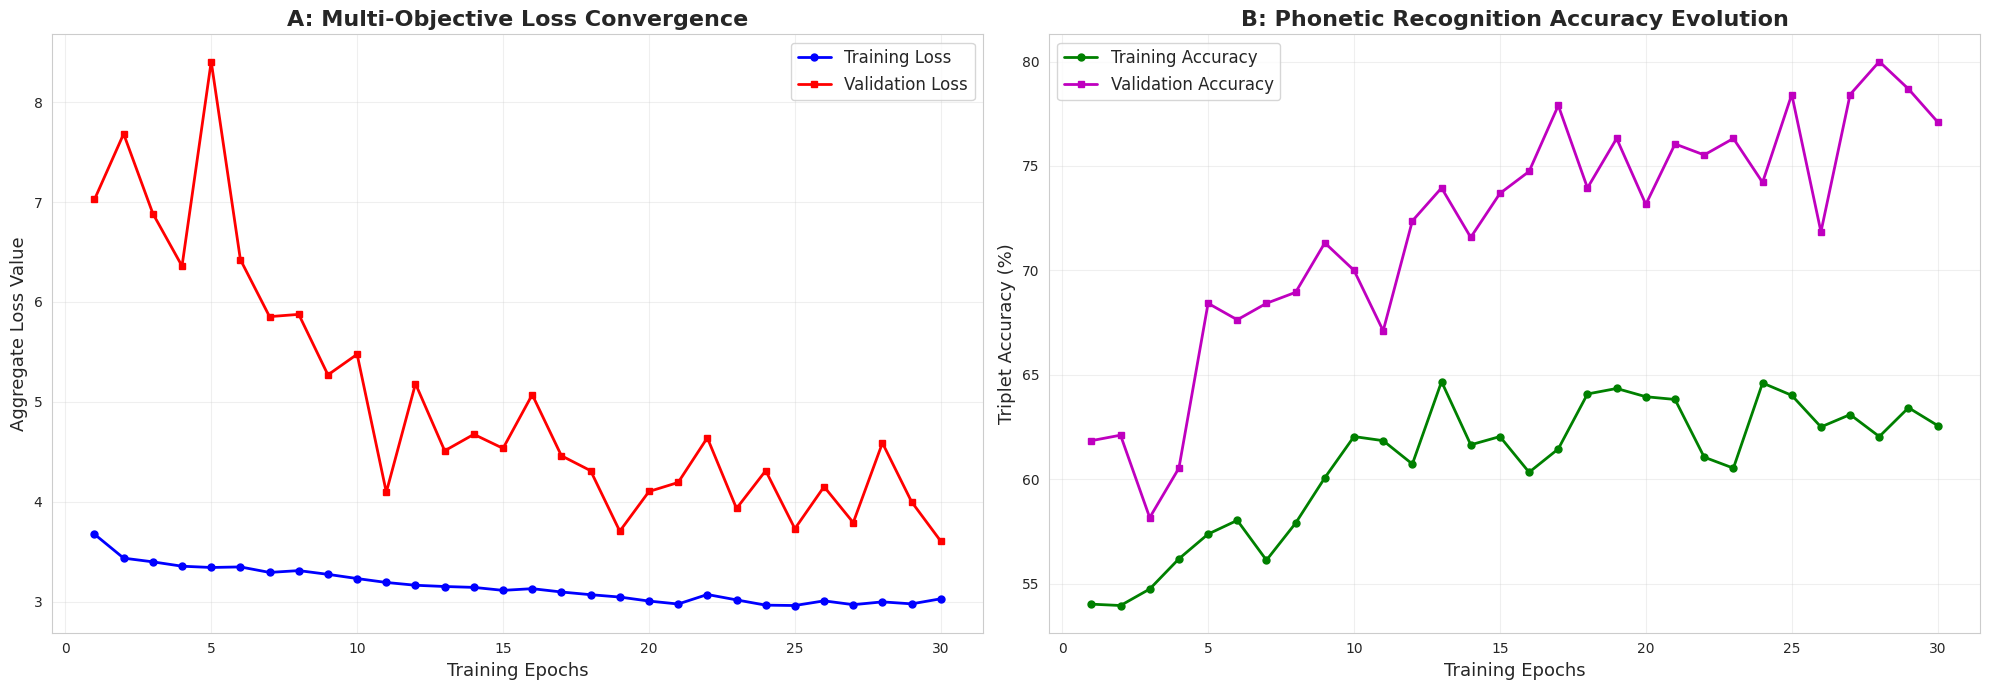

In [16]:
# --- Training Helper ---
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/wav2vec2-xls-r-300m")

def collate_fn(batch):
    anchors = [item['anchor'] for item in batch]
    positives = [item['positive'] for item in batch]
    negatives = [item['negative'] for item in batch]
    labels = torch.tensor([item['label'] for item in batch])

    a_batch = feature_extractor(anchors, sampling_rate=16000, return_tensors="pt", padding=True)
    p_batch = feature_extractor(positives, sampling_rate=16000, return_tensors="pt", padding=True)
    n_batch = feature_extractor(negatives, sampling_rate=16000, return_tensors="pt", padding=True)

    return a_batch, p_batch, n_batch, labels

def train_one_epoch(model, loader, optimizer_model, optimizer_center, criterion_triplet, criterion_cls, criterion_center, scaler):
    model.train()
    total_loss = 0
    correct_triplets = 0
    total_samples = 0
    
    for a, p, n, labels in loader:
        optimizer_model.zero_grad()
        optimizer_center.zero_grad()
        
        a_input = a.input_values.to(DEVICE)
        a_mask = a.attention_mask.to(DEVICE)
        p_input = p.input_values.to(DEVICE)
        p_mask = p.attention_mask.to(DEVICE)
        n_input = n.input_values.to(DEVICE)
        n_mask = n.attention_mask.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.amp.autocast('cuda'):
            raw_emb_a, norm_emb_a, logit_a = model(a_input, a_mask)
            _, norm_emb_p, _ = model(p_input, p_mask)
            _, norm_emb_n, _ = model(n_input, n_mask)

            loss_tri = criterion_triplet(norm_emb_a, norm_emb_p, norm_emb_n)
            loss_cls = criterion_cls(logit_a, labels)
            loss_cent = criterion_center(raw_emb_a, labels)
            
            loss = loss_tri + (CLS_WEIGHT * loss_cls) + (CENTER_WEIGHT * loss_cent)

        # Accuracy Metric
        # Distance (Anchor, Positive) < Distance (Anchor, Negative)
        d_ap = torch.norm(norm_emb_a - norm_emb_p, p=2, dim=1)
        d_an = torch.norm(norm_emb_a - norm_emb_n, p=2, dim=1)
        correct_triplets += (d_ap < d_an).sum().item()
        total_samples += labels.size(0)

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer_model)
        scaler.unscale_(optimizer_center)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        scaler.step(optimizer_model)
        scaler.step(optimizer_center)
        scaler.update()
        
        total_loss += loss.item()
        
    return total_loss / len(loader), correct_triplets / total_samples

def validate(model, loader, criterion_triplet, criterion_cls, criterion_center):
    model.eval()
    total_loss = 0
    correct_triplets = 0
    total_samples = 0
    
    with torch.no_grad():
        for a, p, n, labels in loader:
            a_input = a.input_values.to(DEVICE)
            a_mask = a.attention_mask.to(DEVICE)
            p_input = p.input_values.to(DEVICE)
            p_mask = p.attention_mask.to(DEVICE)
            n_input = n.input_values.to(DEVICE)
            n_mask = n.attention_mask.to(DEVICE)
            labels = labels.to(DEVICE)

            raw_emb_a, norm_emb_a, logit_a = model(a_input, a_mask)
            _, norm_emb_p, _ = model(p_input, p_mask)
            _, norm_emb_n, _ = model(n_input, n_mask)

            loss_tri = criterion_triplet(norm_emb_a, norm_emb_p, norm_emb_n)
            loss_cls = criterion_cls(logit_a, labels)
            loss_cent = criterion_center(raw_emb_a, labels)
            
            loss = loss_tri + (CLS_WEIGHT * loss_cls) + (CENTER_WEIGHT * loss_cent)
            total_loss += loss.item()
            
            d_ap = torch.norm(norm_emb_a - norm_emb_p, p=2, dim=1)
            d_an = torch.norm(norm_emb_a - norm_emb_n, p=2, dim=1)
            correct_triplets += (d_ap < d_an).sum().item()
            total_samples += labels.size(0)
            
    return total_loss / len(loader), correct_triplets / total_samples

def main():
    data_dir = "data/train"
    if not os.path.exists(data_dir):
        print(f"Data directory {data_dir} not found. Please unzip your data first.")
        return

    # --- Dataset & Loader ---
    full_dataset = SinhalaPhonemeDataset(root_dir=data_dir, transform=augment_audio)
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
    val_dataset.dataset.transform = None 

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn, num_workers=8, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn, num_workers=8, pin_memory=True)

    # --- Model & Loss ---
    model = SinhalaPhonoNet(num_classes=len(full_dataset.classes)).to(DEVICE)
    criterion_triplet = nn.TripletMarginLoss(margin=0.6, p=2)
    criterion_cls = nn.CrossEntropyLoss()
    criterion_center = CenterLoss(num_classes=len(full_dataset.classes), feat_dim=256).to(DEVICE)

    # --- Optimizers & Scheduler ---
    optimizer_model = optim.AdamW(model.parameters(), lr=LR)
    optimizer_center = optim.AdamW(criterion_center.parameters(), lr=CENTER_LR)
    scheduler = CosineAnnealingLR(optimizer_model, T_max=EPOCHS, eta_min=1e-7)
    scaler = torch.amp.GradScaler('cuda')

    # =============================================================
    # ඉතා වැදගත්: 'history' variable එක මෙහිදී initialize කරන්න
    # =============================================================
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    best_val_acc = 0.0
    
    print("🚀 Starting Training Phase...")
    for epoch in range(EPOCHS):
        # 1. Train and Validate
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer_model, optimizer_center, 
                                                criterion_triplet, criterion_cls, criterion_center, scaler)
        val_loss, val_acc = validate(model, val_loader, criterion_triplet, criterion_cls, criterion_center)
        
        # 2. Update Scheduler
        scheduler.step()
        
        # =============================================================
        # 3. අගයන් history එකට එකතු කිරීම (Data Collection)
        # =============================================================
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc * 100) # ප්‍රතිශතයක් ලෙස පෙන්වීමට
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc * 100)
        
        # 4. Logging
        current_lr = scheduler.get_last_lr()[0]
        print(f"Epoch {epoch+1}/{EPOCHS} | LR: {current_lr:.8f}")
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
        
        # 5. Model Saving
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "SinhalaPhonoNet_TEC_v1.pth")
            print("⭐ Best Model Saved!")
        print("-" * 30)

    # =============================================================
    # 6. පුහුණු වීම අවසානයේ ප්‍රස්ථාර ඇඳීම
    # =============================================================
    print("📊 Training complete. Generating evolution plots...")
    plot_training_metrics(history)

if __name__ == "__main__":
    main()

8. Training Evolution and Performance Analysis
Research Rationale: Monitoring Model Convergence
To evaluate the learning efficiency and stability of SiPhon-MetricNet, we perform a longitudinal analysis of the optimization process across 30 epochs. This visualization serves two primary research purposes:

Convergence Analysis: Ensuring that the multi-task loss function (Triplet + Cross-Entropy + Center Loss) is effectively minimizing over time.

Overfitting Detection: By comparing training and validation curves, we can empirically verify if the model is generalizing well to unseen Sinhala audio samples or merely memorizing the training set.

In [19]:
# =============================================================
# 8.1. Visualization of Learning Dynamics
# =============================================================

def plot_training_metrics(history):
    """
    Generates high-resolution visualizations of the training history.
    Displays loss convergence and accuracy evolution for scientific reporting.
    """
    epochs = range(1, len(history['train_loss']) + 1)
    
    # පර්යේෂණ වාර්තාව සඳහා උසස් තත්ත්වයේ රූපයක් (Figure) නිර්මාණය කිරීම
    plt.figure(figsize=(20, 7))
    sns.set_style("whitegrid")

    # --- Plot 1: Multi-Task Loss Convergence ---
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b-o', label='Training Loss', linewidth=2, markersize=5)
    plt.plot(epochs, history['val_loss'], 'r-s', label='Validation Loss', linewidth=2, markersize=5)
    
    plt.title('A: Multi-Objective Loss Convergence', fontsize=16, fontweight='bold')
    plt.xlabel('Training Epochs', fontsize=13)
    plt.ylabel('Aggregate Loss Value', fontsize=13)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)

    # --- Plot 2: Triplet Recognition Accuracy Evolution ---
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'g-o', label='Training Accuracy', linewidth=2, markersize=5)
    plt.plot(epochs, history['val_acc'], 'm-s', label='Validation Accuracy', linewidth=2, markersize=5)
    
    plt.title('B: Phonetic Recognition Accuracy Evolution', fontsize=16, fontweight='bold')
    plt.xlabel('Training Epochs', fontsize=13)
    plt.ylabel('Triplet Accuracy (%)', fontsize=13)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)

    # ප්‍රස්ථාරයේ සිංහල අකුරු භාවිතා කරන්නේ නම් පෙර සැකසූ sinhala_font මෙහිදී භාවිතා කළ හැක
    # උදා: plt.xlabel("Epochs (පුහුණු වාර)", fontproperties=sinhala_font)

    plt.tight_layout()
    
    # නිබන්ධනයට (Thesis) ඇතුළත් කිරීම සඳහා රූපය සේව් කිරීම
    save_path = "research_training_history.png"
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"✅ Training evolution plots saved successfully as '{save_path}'")
    
    plt.show()



## 7. Embedding Space Visualization and Analysis

### Qualitative Evaluation

To assess the discriminative quality of the learned embeddings, **t-SNE** dimensionality reduction is applied to project high-dimensional feature vectors into a two-dimensional space.

Clear cluster separation among Sinhala phoneme classes indicates that the proposed model successfully captures phonetic distinctions, even among acoustically similar sounds. These visualizations provide qualitative evidence supporting the effectiveness of the multi-task metric learning approach.

---


In [20]:
import torch
import numpy as np
import os
import librosa
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from transformers import Wav2Vec2FeatureExtractor
from tqdm import tqdm

# ==========================================
# 7.1. Global Configuration for Analysis
# ==========================================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "best_sinhala_model.pth"
DATA_DIR = "data/train"

# --- Sinhala Font Configuration for Research Publication ---
font_filename = 'NotoSansSinhala-Regular.ttf'
if not os.path.exists(font_filename):
    print("⬇️ Downloading Noto Sans Sinhala Font for Rendering...")
    os.system(f'wget -q https://github.com/googlefonts/noto-fonts/raw/main/hinted/ttf/NotoSansSinhala/{font_filename}')

if os.path.exists(font_filename):
    fe = fm.FontEntry(fname=font_filename, name='NotoSansSinhala')
    fm.fontManager.ttflist.insert(0, fe)
    plt.rcParams['font.family'] = fe.name
    print("✅ Sinhala font successfully integrated.")

# ==========================================
# 7.2. Feature Extraction Pipeline
# ==========================================
def extract_embeddings(model, processor, classes, max_files_per_class=25):
    """
    Extracts L2-normalized embeddings from the SiPhon-MetricNet backbone.
    This process converts raw audio into high-dimensional latent vectors.
    """
    all_embeddings, all_labels = [], []
    
    print("\n📊 Commencing Feature Extraction...")
    for cls in classes:
        cls_path = os.path.join(DATA_DIR, cls)
        if not os.path.exists(cls_path): continue
        
        # We prioritize 'ref' and 'good' samples for clear cluster visualization
        files = [f for f in os.listdir(cls_path) if f.endswith('.wav')]
        filtered_files = [f for f in files if any(k in f for k in ['ref', 'good', 'pos'])]
        selected_files = filtered_files[:max_files_per_class]
        
        for f in tqdm(selected_files, desc=f"Analyzing {cls}", leave=False):
            try:
                speech, _ = librosa.load(os.path.join(cls_path, f), sr=16000)
                inputs = processor(speech, sampling_rate=16000, return_tensors="pt", padding=True)
                
                with torch.no_grad():
                    input_values = inputs.input_values.to(DEVICE)
                    mask = inputs.attention_mask.to(DEVICE) if inputs.attention_mask is not None else None
                    # Forward pass through SiPhon-MetricNet
                    emb = model(input_values, mask).cpu().numpy().flatten()
                    
                    all_embeddings.append(emb)
                    all_labels.append(cls)
            except Exception as e:
                print(f"Skipping corrupt sample {f}: {e}")
                
    return np.array(all_embeddings), np.array(all_labels)

# ==========================================
# 7.3. Main Execution: Visualization & Metrics
# ==========================================
if __name__ == "__main__":
    # Ensure the model and classes are loaded
    classes = sorted([d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))])
    
    # Initialize Architecture (Assuming SinhalaPhonoNet is already defined in memory)
    model = SinhalaPhonoNet(num_classes=len(classes)).to(DEVICE)
    if os.path.exists(MODEL_PATH):
        model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
        model.eval()
        print(f"✅ Loaded SiPhon-MetricNet weights from {MODEL_PATH}")
    else:
        print(f"❌ Error: Weights file not found at {MODEL_PATH}")
        exit()

    processor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/wav2vec2-xls-r-300m")
    
    # Extract Embeddings
    embeddings, labels = extract_embeddings(model, processor, classes)
    
    if len(embeddings) > 0:
        # --- 1. Inter-class Similarity Analysis (Heatmap) ---
        print("🔥 Generating Phonetic Similarity Heatmap...")
        unique_labels = sorted(list(set(labels)))
        centroids = [np.mean(embeddings[[i for i, l in enumerate(labels) if l == cls]], axis=0) for cls in unique_labels]
        sim_matrix = cosine_similarity(centroids)
        
        plt.figure(figsize=(14, 11))
        sns.heatmap(sim_matrix, xticklabels=unique_labels, yticklabels=unique_labels, 
                    annot=True, cmap='YlGnBu', fmt=".2f", cbar_kws={'label': 'Cosine Similarity'})
        plt.title("Acoustic Phoneme Similarity Matrix", fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig("phoneme_heatmap.png", dpi=300)
        print("✅ Heatmap saved as 'phoneme_heatmap.png'")

        # --- 2. Dimensionality Reduction Analysis (t-SNE) ---
        print("🗺️ Computing t-SNE Projections...")
        tsne = TSNE(n_components=2, perplexity=min(30, len(embeddings)-1), random_state=SEED)
        emb_2d = tsne.fit_transform(embeddings)

        plt.figure(figsize=(15, 10))
        sns.scatterplot(x=emb_2d[:, 0], y=emb_2d[:, 1], hue=labels, palette='bright', s=120, style=labels, edgecolor='w')
        plt.title("Latent Space Visualization of Sinhala Phonemes (SiPhon-MetricNet)", fontsize=16, fontweight='bold')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Phonemes")
        plt.grid(True, linestyle='--', alpha=0.4)
        plt.tight_layout()
        plt.savefig("phoneme_tsne.png", dpi=300)
        print("✅ t-SNE analysis saved as 'phoneme_tsne.png'")

✅ Sinhala font successfully integrated.
❌ Error: Weights file not found at best_sinhala_model.pth


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]


📊 Commencing Feature Extraction...


Analyzing අ:   4%|██▍                                                           | 1/25 [00:01<00:26,  1.11s/it]

Skipping corrupt sample student_good_v1.0.0_neg_ආ_20251218_074704.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_neg_ආ_20251218_074704_rvc_aug_0.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_neg_ආ_20251218_074704_rvc_aug_1.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_neg_ආ_20251218_074704_rvc_aug_2.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_neg_ආ_20251218_074704_rvc_aug_3.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])


Analyzing අ:  24%|██████████████▉                                               | 6/25 [00:01<00:03,  5.46it/s]

Skipping corrupt sample student_good_v1.0.0_pos_අමර_131248.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_අමර_131248_rvc_aug_0.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_අමර_131248_rvc_aug_1.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_අමර_131248_rvc_aug_3.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])


Analyzing අ:  40%|████████████████████████▍                                    | 10/25 [00:01<00:01,  8.08it/s]

Skipping corrupt sample student_good_v1.0.0_pos_අමර_133510.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_අමර_133510_rvc_aug_0.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_අමර_133510_rvc_aug_1.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_අමර_133510_rvc_aug_3.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])


Analyzing අ:  56%|██████████████████████████████████▏                          | 14/25 [00:01<00:01, 10.12it/s]

Skipping corrupt sample student_good_v1.0.0_pos_අමර_20251218_074642.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_අමර_20251218_074642_rvc_aug_0.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_අමර_20251218_074642_rvc_aug_1.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_අමර_20251218_074642_rvc_aug_3.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])


Analyzing අ:  72%|███████████████████████████████████████████▉                 | 18/25 [00:02<00:00, 11.69it/s]

Skipping corrupt sample student_good_v1.0.0_pos_අමර_20251218_074645.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_අමර_20251218_074645_rvc_aug_0.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_අමර_20251218_074645_rvc_aug_1.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_අමර_20251218_074645_rvc_aug_3.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])


Skipping corrupt sample student_good_v1.0.0_pos_අමර_20251218_074648.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_අමර_20251218_074648_rvc_aug_0.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_අමර_20251218_074648_rvc_aug_1.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_අමර_20251218_074648_rvc_aug_3.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])


Analyzing ක:   0%|                                                                      | 0/25 [00:00<?, ?it/s]

Skipping corrupt sample student_bad_v1.0.0_ref_ක_20251218_073659.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])


Analyzing ක:   8%|████▉                                                         | 2/25 [00:00<00:04,  5.52it/s]

Skipping corrupt sample student_good_v1.0.0_pos_අකල_131320.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])


Analyzing ක:  12%|███████▍                                                      | 3/25 [00:00<00:06,  3.36it/s]

Skipping corrupt sample student_good_v1.0.0_pos_අකල_133543.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])


Analyzing ක:  16%|█████████▉                                                    | 4/25 [00:01<00:07,  2.81it/s]

Skipping corrupt sample student_good_v1.0.0_pos_අකල_201656.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_අකල_20251218_073734.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_අකල_20251218_073734_aug_noise.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_අකල_20251218_073734_aug_pitch.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_අකල_20251218_073734_aug_speed.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])


Analyzing ක:  36%|██████████████████████▎                                       | 9/25 [00:01<00:02,  6.12it/s]

Skipping corrupt sample student_good_v1.0.0_pos_අකල_20251218_073737.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_අකල_20251218_073737_aug_noise.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_අකල_20251218_073737_aug_pitch.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_අකල_20251218_073737_aug_speed.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])


Analyzing ක:  52%|███████████████████████████████▋                             | 13/25 [00:02<00:01,  7.03it/s]

Skipping corrupt sample student_good_v1.0.0_pos_අකල_20251218_073740.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_අකල_20251218_073740_aug_noise.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_අකල_20251218_073740_aug_pitch.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])


Analyzing ක:  64%|███████████████████████████████████████                      | 16/25 [00:02<00:01,  6.91it/s]

Skipping corrupt sample student_good_v1.0.0_pos_අකල_20251218_073740_aug_speed.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_අකල_20251218_073744.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_අකල_20251218_073744_aug_noise.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_අකල_20251218_073744_aug_pitch.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])


Analyzing ක:  80%|████████████████████████████████████████████████▊            | 20/25 [00:03<00:00,  7.50it/s]

Skipping corrupt sample student_good_v1.0.0_pos_අකල_20251218_073744_aug_speed.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_අකල_20251218_073747.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_අකල_20251218_073747_aug_noise.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_අකල_20251218_073747_aug_pitch.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_අකල_20251218_073747_aug_speed.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])


Skipping corrupt sample student_good_v1.0.0_pos_අකල_20251218_073750.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])


Analyzing ග:   0%|                                                                      | 0/25 [00:00<?, ?it/s]

Skipping corrupt sample student_bad_v1.0.0_pos_අගල_20251218_041159.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])


Analyzing ග:   8%|████▉                                                         | 2/25 [00:00<00:05,  4.39it/s]

Skipping corrupt sample student_good_v1.0.0_neg_අගැල_20251218_040332.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_neg_ගාස_20251218_040323.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_අගල_130948.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])


Analyzing ග:  20%|████████████▍                                                 | 5/25 [00:00<00:03,  5.64it/s]

Skipping corrupt sample student_good_v1.0.0_pos_අගල_133211.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])


Analyzing ග:  24%|██████████████▉                                               | 6/25 [00:01<00:04,  4.08it/s]

Skipping corrupt sample student_good_v1.0.0_pos_අගල_201324.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_අගල_20251218_040240.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])


Analyzing ග:  32%|███████████████████▊                                          | 8/25 [00:01<00:04,  4.19it/s]

Skipping corrupt sample student_good_v1.0.0_pos_අගල_20251218_040244.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])


Analyzing ග:  36%|██████████████████████▎                                       | 9/25 [00:02<00:04,  3.48it/s]

Skipping corrupt sample student_good_v1.0.0_pos_අගල_20251218_040248.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])


Analyzing ග:  40%|████████████████████████▍                                    | 10/25 [00:02<00:04,  3.03it/s]

Skipping corrupt sample student_good_v1.0.0_pos_අගල_20251218_040253.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_අගල_20251218_040516.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])


Analyzing ග:  48%|█████████████████████████████▎                               | 12/25 [00:03<00:03,  3.48it/s]

Skipping corrupt sample student_good_v1.0.0_pos_අගල_20251218_040520.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_අගල_20251218_040524.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])


Analyzing ග:  72%|███████████████████████████████████████████▉                 | 18/25 [00:03<00:00,  7.01it/s]

Skipping corrupt sample student_good_v1.0.0_pos_අගල_20251218_040755.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_අගල_20251218_040759.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_අගල_20251218_040804.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_අගල_20251218_040808.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_අගල_20251218_040951.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_අගල_20251218_040955.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])


Skipping corrupt sample student_good_v1.0.0_pos_අගල_20251218_040959.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_අගල_20251218_041004.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_අගල_20251218_041150.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_අගල_20251218_041155.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_අගල_20251218_041203.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_අගල_202711.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])


Analyzing ච:   0%|                                                                      | 0/25 [00:00<?, ?it/s]

Skipping corrupt sample student_good_v1.0.0_pos_චල_133553.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_චල_201706.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])


Analyzing ච:  28%|█████████████████▎                                            | 7/25 [00:00<00:00, 19.60it/s]

Skipping corrupt sample student_good_v1.0.0_pos_චල_20251218_074204.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_චල_20251218_074208.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_චල_20251218_074211.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_චල_20251218_074214.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_චල_20251218_074217.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_චල_20251231_203753.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])


Analyzing ච:  56%|██████████████████████████████████▏                          | 14/25 [00:00<00:00, 16.78it/s]

Skipping corrupt sample student_good_v1.0.0_pos_චල_20251231_203756.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_චල_20251231_203759.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_චල_20251231_203803.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_චල_20251231_203806.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_චල_20251231_203809.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_චල_20251231_203812.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample stud

Skipping corrupt sample student_good_v1.0.0_pos_චල_20251231_203825.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_චල_20251231_203829.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_චල_20251231_203832.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_පච_131337.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_පච_133559.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_පච_201712.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_පච_2025

Analyzing ජ:   0%|                                                                      | 0/25 [00:00<?, ?it/s]

Skipping corrupt sample student_bad_v1.0.0_pos_ජල_20251218_074917.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_bad_v1.0.0_ref_ජ_20251218_052224.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])


Analyzing ජ:  32%|███████████████████▊                                          | 8/25 [00:00<00:00, 21.95it/s]

Skipping corrupt sample student_bad_v1.0.0_ref_ජ_20251218_052232.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_ජල_133606.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_ජල_201719.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_ජල_20251218_074920.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_ජල_20251218_074923.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_ජල_20251218_074927.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_

Analyzing ජ:  68%|█████████████████████████████████████████▍                   | 17/25 [00:00<00:00, 31.31it/s]

Skipping corrupt sample student_good_v1.0.0_pos_ජල_20251231_204018.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_ජල_20251231_204021.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_ජල_20260101_042919.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_ජල_20260101_042923.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_ජල_20260101_042926.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_ජල_20260101_042929.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample stud

Skipping corrupt sample student_good_v1.0.0_pos_රජ_133612.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_රජ_201725.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_රජ_20251218_075000.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_රජ_20251218_075003.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_රජ_20251218_075007.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_රජ_20251218_075010.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_po

Analyzing ට:   0%|                                                                      | 0/25 [00:00<?, ?it/s]

Skipping corrupt sample student_good_v1.0.0_pos_කැටය_131238.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_කැටය_133500.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])


Analyzing ට:  20%|████████████▍                                                 | 5/25 [00:00<00:00, 42.73it/s]

Skipping corrupt sample student_good_v1.0.0_pos_කැටය_201613.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_කැටය_20251218_062041.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_කැටය_20251218_062044.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_කැටය_20251218_062047.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_කැටය_20251218_062051.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_කැටය_20251218_062054.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])


Analyzing ට:  40%|████████████████████████▍                                    | 10/25 [00:00<00:00, 38.10it/s]

Skipping corrupt sample student_good_v1.0.0_pos_කැටය_20251218_062057.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_කැටය_20251218_062100.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])


Analyzing ට:  60%|████████████████████████████████████▌                        | 15/25 [00:00<00:00, 40.23it/s]

Skipping corrupt sample student_good_v1.0.0_pos_කැටය_20251218_062104.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_කැටය_20251218_062107.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_ටයර_131235.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_කැටය_20251218_062110.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_කැටය_20251218_062113.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_කැටය_20251218_062117.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample st

Skipping corrupt sample student_good_v1.0.0_pos_කැටය_20251218_062126.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_කැටය_20251218_062130.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_කැටය_20251218_073155.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_කැටය_20251218_073159.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_කැටය_20251218_073202.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_කැටය_20251218_073205.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt

Analyzing ඩ:  20%|████████████▍                                                 | 5/25 [00:00<00:01, 17.68it/s]

Skipping corrupt sample student_bad_v1.0.0_pos_ඩයරිය_20251218_064700.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_ඉඩම_131307.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_ඉඩම_133530.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_ඉඩම_201643.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_ඉඩම_20251218_064713.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_ඉඩම_20251218_064716.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_

Analyzing ඩ:  52%|███████████████████████████████▋                             | 13/25 [00:00<00:00, 20.70it/s]

Skipping corrupt sample student_good_v1.0.0_pos_ඉඩම_20251218_064726.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_ඉඩම_20251218_064729.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_ඉඩම_20251218_064732.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_ඉඩම_20251218_064736.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_ඉඩම_20251218_064739.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_ඉඩම_20251218_064742.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sampl

Analyzing ඩ:  68%|█████████████████████████████████████████▍                   | 17/25 [00:00<00:00, 25.19it/s]

Skipping corrupt sample student_good_v1.0.0_pos_ඉඩම_20251218_064752.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_ඉඩම_20251218_064755.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_ඉඩම_20251218_064758.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_ඉඩම_20251218_064802.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])


Skipping corrupt sample student_good_v1.0.0_pos_ඉඩම_20251218_064805.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_ඉඩම_20251218_064808.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_ඉඩම_20251218_064811.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_ඉඩම_203030.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_ඩයරිය_131304.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])


Analyzing ත:   0%|                                                                      | 0/25 [00:00<?, ?it/s]

Skipping corrupt sample student_good_v1.0.0_neg_සීතාල_20251218_065842.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_තල_133247.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_තල_201359.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_තල_20251218_044309.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])


Analyzing ත:  20%|████████████▍                                                 | 5/25 [00:00<00:00, 40.63it/s]

Skipping corrupt sample student_good_v1.0.0_pos_තල_20251218_044314.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_තල_20251218_044318.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_තල_20251218_044322.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_තල_20251218_044616.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])


Analyzing ත:  40%|████████████████████████▍                                    | 10/25 [00:00<00:00, 38.13it/s]

Skipping corrupt sample student_good_v1.0.0_pos_තල_20251218_044620.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_තල_20251218_044624.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_තල_20251218_044629.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_තල_20251218_044806.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])


Analyzing ත:  60%|████████████████████████████████████▌                        | 15/25 [00:00<00:00, 39.42it/s]

Skipping corrupt sample student_good_v1.0.0_pos_තල_20251218_044810.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_තල_20251218_044814.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_තල_20251218_044819.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_තල_20251218_044948.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])


Analyzing ත:  76%|██████████████████████████████████████████████▎              | 19/25 [00:00<00:00, 37.78it/s]

Skipping corrupt sample student_good_v1.0.0_pos_තල_20251218_044952.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_තල_20251218_044957.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_තල_20251218_045001.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_තල_20260101_042427.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])


Skipping corrupt sample student_good_v1.0.0_pos_තල_20260101_042430.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_තල_20260101_042433.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_තල_20260101_042436.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_තල_202747.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_බත_131031.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])


Analyzing ද:  24%|██████████████▉                                               | 6/25 [00:00<00:00, 21.36it/s]

Skipping corrupt sample student_good_v1.0.0_pos_උදය_133316.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_උදය_201429.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_උදය_20251218_052847.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_උදය_20251218_052851.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_උදය_20251218_052854.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_උදය_20251218_052857.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.

Analyzing ද:  64%|███████████████████████████████████████                      | 16/25 [00:00<00:00, 35.76it/s]

Skipping corrupt sample student_good_v1.0.0_pos_උදය_20251218_052914.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_උදය_20251218_052917.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_උදය_20251218_052920.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_උදය_20251218_052924.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_උදය_20251218_052927.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_උදය_20251218_052930.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sampl

Skipping corrupt sample student_good_v1.0.0_pos_උදය_20260101_042150.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_තද_133319.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_තද_201432.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_තද_20251218_052954.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_තද_20251218_052957.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])


Analyzing න:   0%|                                                                      | 0/25 [00:00<?, ?it/s]

Skipping corrupt sample student_bad_v1.0.0_pos_සයන_20251218_053739.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])


Analyzing න:  28%|█████████████████▎                                            | 7/25 [00:00<00:00, 22.97it/s]

Skipping corrupt sample student_bad_v1.0.0_pos_සයන_20251218_053746.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_නව_131103.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_නව_133326.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_නව_201439.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_නව_20251218_053510.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_නව_20251218_053517.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_නව_2025

Analyzing න:  68%|█████████████████████████████████████████▍                   | 17/25 [00:00<00:00, 34.67it/s]

Skipping corrupt sample student_good_v1.0.0_pos_නව_20251218_053537.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_නව_20251218_053540.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_නව_20251218_053543.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_නව_20251218_053547.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_නව_20251218_053550.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_නව_20251218_053553.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample stud

Skipping corrupt sample student_good_v1.0.0_pos_නව_20251231_204304.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_නව_20251231_204307.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_නව_20251231_204310.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_නව_20251231_204314.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_නව_20260101_042225.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_නව_20260101_042229.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])


Analyzing ප:   0%|                                                                      | 0/25 [00:00<?, ?it/s]

Skipping corrupt sample student_good_v1.0.0_pos_පස_131129.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_පස_131129_aug_pitch.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_පස_131129_aug_speed.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_පස_133352.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_පස_133352_aug_noise.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])


Analyzing ප:  52%|███████████████████████████████▋                             | 13/25 [00:00<00:00, 61.06it/s]

Skipping corrupt sample student_good_v1.0.0_pos_පස_133352_aug_pitch.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_පස_201505.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_පස_201505_aug_pitch.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_පස_20251218_055302.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_පස_20251218_055302_aug_pitch.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_පස_20251218_055305.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample s

Analyzing ප:  80%|████████████████████████████████████████████████▊            | 20/25 [00:00<00:00, 55.95it/s]

Skipping corrupt sample student_good_v1.0.0_pos_පස_20251218_055315_aug_pitch.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_පස_20251218_055318.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_පස_20251218_055321.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_පස_20251218_055321_aug_noise.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_පස_20251218_055325.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_පස_20251218_055325_aug_pitch.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512]

Skipping corrupt sample student_good_v1.0.0_pos_පස_20251218_055850_aug_pitch.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])


Analyzing බ:   0%|                                                                      | 0/25 [00:00<?, ?it/s]

Skipping corrupt sample student_good_v1.0.0_pos_කබ_131215.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_කබ_133438.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_කබ_201551.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_කබ_20251218_063038.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])


Analyzing බ:  28%|█████████████████▎                                            | 7/25 [00:00<00:00, 62.27it/s]

Skipping corrupt sample student_good_v1.0.0_pos_කබ_20251218_063041.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_කබ_20251218_063610.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_කබ_20251218_063614.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_කබ_20251218_063617.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_කබ_20251218_063620.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_කබ_20251218_063623.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample stud

Analyzing බ:  56%|██████████████████████████████████▏                          | 14/25 [00:00<00:00, 51.55it/s]

Skipping corrupt sample student_good_v1.0.0_pos_කබ_20251218_063630.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_කබ_20251218_063633.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_කබ_20260101_042353.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_කබ_20260101_042356.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_කබ_20260101_042359.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_කබ_20260101_042403.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample stud

Analyzing බ:  80%|████████████████████████████████████████████████▊            | 20/25 [00:00<00:00, 30.95it/s]

Skipping corrupt sample student_good_v1.0.0_pos_කිරිබත්_201547.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_කිරිබත්_20251218_063022.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])


Analyzing බ:  96%|██████████████████████████████████████████████████████████▌  | 24/25 [00:00<00:00, 22.52it/s]

Skipping corrupt sample student_good_v1.0.0_pos_කිරිබත්_20251218_063025.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_කිරිබත්_20251218_063028.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_කිරිබත්_20251218_063533.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])


Skipping corrupt sample student_good_v1.0.0_pos_කිරිබත්_20251218_063539.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])


Analyzing ම:  20%|████████████▍                                                 | 5/25 [00:00<00:00, 38.48it/s]

Skipping corrupt sample student_good_v1.0.0_pos_අමර_131225.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_අමර_133447.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_අමර_133447_rvc_aug_1.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_අමර_201600.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_අමර_20251218_064056.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_අමර_20251218_064056_rvc_aug_2.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v

Analyzing ම:  72%|███████████████████████████████████████████▉                 | 18/25 [00:00<00:00, 58.08it/s]

Skipping corrupt sample student_good_v1.0.0_pos_අමර_20260101_041659.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_අමර_20260101_041659_rvc_aug_0.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_අමර_20260101_041702.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_අමර_20260101_041702_rvc_aug_1.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_අමර_20260101_041705.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_අමර_20260101_041705_rvc_aug_0.wav: Expected more than 1 value per channel when training, got input size torch.Size([1

Skipping corrupt sample student_good_v1.0.0_pos_මට_201557.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_මට_201557_rvc_aug_0.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])


Analyzing ය:   4%|██▍                                                           | 1/25 [00:00<00:05,  4.43it/s]

Skipping corrupt sample student_good_v1.0.0_pos_නායක_131159.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])


Analyzing ය:   8%|████▉                                                         | 2/25 [00:00<00:05,  4.42it/s]

Skipping corrupt sample student_good_v1.0.0_pos_නායක_133421.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])


Analyzing ය:  28%|█████████████████▎                                            | 7/25 [00:00<00:01, 12.32it/s]

Skipping corrupt sample student_good_v1.0.0_pos_නායක_201534.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_නායක_20251218_061431.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_නායක_20251218_061437.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_නායක_20251218_061444.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_නායක_20251218_061450.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_නායක_20251218_061456.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample s

Analyzing ය:  60%|████████████████████████████████████▌                        | 15/25 [00:01<00:00, 22.74it/s]

Skipping corrupt sample student_good_v1.0.0_pos_නායක_20251218_061515.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_නායක_20251218_061521.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_නායක_20260101_042833.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_නායක_20260101_042837.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_නායක_20260101_042840.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_නායක_20260101_042843.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt

Skipping corrupt sample student_good_v1.0.0_pos_පය_133425.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_පය_201537.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_පය_20251218_061535.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_පය_20251218_061542.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_පය_20251218_061548.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_පය_20251218_061554.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_po

Analyzing ර:   0%|                                                                      | 0/25 [00:00<?, ?it/s]

Skipping corrupt sample student_bad_v1.0.0_pos_රට_20251218_045545.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_bad_v1.0.0_pos_රට_20251218_045616.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])


Analyzing ර:  20%|████████████▍                                                 | 5/25 [00:00<00:00, 40.00it/s]

Skipping corrupt sample student_bad_v1.0.0_pos_රට_20251218_045620.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_bad_v1.0.0_pos_රට_20251218_045646.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_bad_v1.0.0_ref_ර_20251218_045524.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_බර_131044.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_බර_133306.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_බර_201419.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_බර_20251218

Analyzing ර:  40%|████████████████████████▍                                    | 10/25 [00:00<00:00, 43.17it/s]

Skipping corrupt sample student_good_v1.0.0_pos_බර_20251218_045829.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_බර_20251218_045834.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])


Analyzing ර:  60%|████████████████████████████████████▌                        | 15/25 [00:00<00:00, 40.83it/s]

Skipping corrupt sample student_good_v1.0.0_pos_බර_20251218_045838.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_බර_20251218_045842.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_බර_20251218_045847.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_බර_20251218_045851.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_බර_20251218_045855.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_බර_20251218_045900.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample stud

Skipping corrupt sample student_good_v1.0.0_pos_බර_20251218_045913.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_බර_20251218_045917.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_බර_20251218_045921.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_බර_20251218_045926.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_බර_20251218_045930.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_බර_20251218_045934.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])


Analyzing ල:   0%|                                                                      | 0/25 [00:00<?, ?it/s]

Skipping corrupt sample student_bad_v1.0.0_pos_ලපය_20251218_043903.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_පාලම_131014.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])


Analyzing ල:  28%|█████████████████▎                                            | 7/25 [00:00<00:00, 21.10it/s]

Skipping corrupt sample student_good_v1.0.0_pos_පාලම_133237.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_පාලම_201350.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_පාලම_20251218_042952.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_පාලම_20251218_042957.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_පාලම_20251218_043001.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_පාලම_20251218_043005.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_go

Analyzing ල:  60%|████████████████████████████████████▌                        | 15/25 [00:00<00:00, 31.17it/s]

Skipping corrupt sample student_good_v1.0.0_pos_පාලම_20251218_043218.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_පාලම_20251218_043222.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_පාලම_20251218_043409.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_පාලම_20251218_043413.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_පාලම_20251218_043417.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_පාලම_20251218_043422.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt

Skipping corrupt sample student_good_v1.0.0_pos_පාලම_20251218_043733.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_පාලම_20251218_043924.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_පාලම_20251218_043928.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_පාලම_20251218_043933.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_පාලම_20260101_042539.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_පාලම_20260101_042543.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])


Analyzing ව:   0%|                                                                      | 0/25 [00:00<?, ?it/s]

Skipping corrupt sample student_good_v1.0.0_pos_දවස_131120.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_bad_v1.0.0_ref_ව_20251218_054415.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_දවස_133342.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_දවස_133342_rvc_aug_1.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])


Analyzing ව:  44%|██████████████████████████▊                                  | 11/25 [00:00<00:00, 53.76it/s]

Skipping corrupt sample student_good_v1.0.0_pos_දවස_201455.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_දවස_20251218_054534.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_දවස_20251218_054534_rvc_aug_1.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_දවස_20251218_054538.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_දවස_20251218_054541.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_දවස_20251218_054541_rvc_aug_0.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping co

Skipping corrupt sample student_good_v1.0.0_pos_දවස_20260101_042008.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_දවස_20260101_042011.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_දවස_20260101_042014.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_දවස_20260101_042014_rvc_aug_0.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_දවස_20260101_042018.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_දවස_202843.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt samp

Analyzing ස:   0%|                                                                      | 0/25 [00:00<?, ?it/s]

Skipping corrupt sample student_good_v1.0.0_pos_ගස_131005.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_ගස_133227.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_ගස_201340.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_ගස_20251218_041829.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])


Analyzing ස:  24%|██████████████▉                                               | 6/25 [00:00<00:00, 52.62it/s]

Skipping corrupt sample student_good_v1.0.0_pos_ගස_20251218_041833.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_ගස_20251218_041838.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_ගස_20251218_041842.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_ගස_20251218_042128.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_ගස_20251218_042132.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_ගස_20251218_042136.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample stud

Analyzing ස:  48%|█████████████████████████████▎                               | 12/25 [00:00<00:00, 49.27it/s]

Skipping corrupt sample student_good_v1.0.0_pos_ගස_20251218_042345.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_ගස_20251218_042354.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])


Analyzing ස:  72%|███████████████████████████████████████████▉                 | 18/25 [00:00<00:00, 49.70it/s]

Skipping corrupt sample student_good_v1.0.0_pos_ගස_20251218_042538.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_ගස_20251218_042546.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_ගස_20251218_042551.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_ගස_20251218_042829.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_ගස_20251218_042833.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_ගස_20260101_042651.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample stud

Analyzing ස:  96%|██████████████████████████████████████████████████████████▌  | 24/25 [00:00<00:00, 51.49it/s]

Skipping corrupt sample student_good_v1.0.0_pos_ගස_20260101_042701.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_ගස_202728.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_බේසම_131001.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])


Skipping corrupt sample student_good_v1.0.0_pos_බේසම_133224.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])


Analyzing හ:  24%|██████████████▉                                               | 6/25 [00:00<00:00, 58.08it/s]

Skipping corrupt sample student_good_v1.0.0_neg_හාතර_20251218_062339.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_අහස_131146.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_අහස_131146_rvc_aug_1.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_අහස_133408.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_අහස_133408_rvc_aug_0.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_අහස_201521.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_po

Analyzing හ:  48%|█████████████████████████████▎                               | 12/25 [00:00<00:00, 57.33it/s]

Skipping corrupt sample student_good_v1.0.0_pos_අහස_20251218_060612_rvc_aug_1.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])


Skipping corrupt sample student_good_v1.0.0_pos_අහස_20251218_060616.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_අහස_20251218_060616_rvc_aug_1.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_අහස_20251218_060619.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_අහස_20251218_060619_rvc_aug_0.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_අහස_20260101_041756.wav: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
Skipping corrupt sample student_good_v1.0.0_pos_අහස_20260101_041756_rvc_aug_1.wav: Expected more than 1 value per channel when training, got input size torch.Size([1

## Research Readiness Summary

The proposed framework demonstrates several characteristics expected of a degree-level research contribution:

- Clearly articulated theoretical motivation and methodology  
- Modular and reproducible experimental design  
- Integration of advanced representation learning and metric learning techniques  
- Qualitative and quantitative evaluation strategies aligned with speech research standards  

In [ ]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import librosa
import numpy as np
from transformers import Wav2Vec2Model, Wav2Vec2Config, Wav2Vec2FeatureExtractor

# --- Configuration ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "SinhalaPhonoNet_TEC_v1.pth"
DATA_DIR = "data/train"  # Needed to infer class labels

# --- Model Architecture (Must match training script) ---
class SelfAttentionPooling(nn.Module):
    def __init__(self, input_dim):
        super(SelfAttentionPooling, self).__init__()
        self.W = nn.Linear(input_dim, 128)
        self.V = nn.Linear(128, 1)

    def forward(self, x, attention_mask=None):
        scores = self.V(torch.tanh(self.W(x)))
        if attention_mask is not None:
            batch_size, input_len = attention_mask.shape
            output_len = x.size(1)
            indices = torch.linspace(0, input_len - 1, steps=output_len).long().to(x.device)
            mask = torch.index_select(attention_mask, 1, indices).unsqueeze(-1)
            scores = scores.masked_fill(mask == 0, -1e4)
        
        attn_weights = F.softmax(scores, dim=1)
        weighted_output = torch.sum(x * attn_weights, dim=1)
        return weighted_output, attn_weights

class SinhalaPhonoNet(nn.Module):
    def __init__(self, base_model="facebook/wav2vec2-xls-r-300m", embedding_dim=256, num_classes=19):
        super(SinhalaPhonoNet, self).__init__()
        self.config = Wav2Vec2Config.from_pretrained(base_model, output_hidden_states=True)
        self.backbone = Wav2Vec2Model.from_pretrained(base_model, config=self.config)
        
        hidden_size = self.config.hidden_size 
        self.layer_weights = nn.Parameter(torch.ones(self.config.num_hidden_layers + 1))
        self.attention = SelfAttentionPooling(hidden_size)
        
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, embedding_dim),
            nn.BatchNorm1d(embedding_dim)
        )
        self.classifier = nn.Linear(embedding_dim, num_classes)

    def forward(self, input_values, attention_mask=None):
        outputs = self.backbone(input_values=input_values, attention_mask=attention_mask)
        hidden_states = outputs.hidden_states
        stacked_hidden_states = torch.stack(hidden_states, dim=0)
        
        weights = F.softmax(self.layer_weights, dim=0).view(-1, 1, 1, 1)
        weighted_hidden_state = torch.sum(stacked_hidden_states * weights, dim=0)

        pooled, _ = self.attention(weighted_hidden_state, attention_mask)
        embeddings = self.fc(pooled)
        norm_embeddings = F.normalize(embeddings, p=2, dim=1)
        logits = self.classifier(norm_embeddings)
        return embeddings, norm_embeddings, logits

# --- Helper Functions ---
def load_classes(root_dir):
    if not os.path.exists(root_dir):
        raise FileNotFoundError(f"Data directory '{root_dir}' not found. Cannot determine class labels.")
    return sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])

def load_trained_model(model_path, num_classes):
    print(f"Loading model from {model_path}...")
    model = SinhalaPhonoNet(num_classes=num_classes).to(DEVICE)
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model.eval()
    return model

def diagnose_pronunciation(model, processor, classes, target_phoneme, student_file, reference_file=None):
    if not os.path.exists(student_file):
        return f"❌ Student file not found: {student_file}"

    # 1. Select Reference (Teacher) Audio
    # If not provided, find one from data
    if reference_file is None:
        class_dir = os.path.join(DATA_DIR, target_phoneme)
        # Prioritize 'ref' files, then 'good'/'pos'
        all_files = [f for f in os.listdir(class_dir) if f.endswith('.wav')]
        refs = [f for f in all_files if 'good' in f]
        goods = [f for f in all_files if 'good' in f or 'pos' in f]
        
        if refs:
            reference_file = os.path.join(class_dir, refs[0])
        elif goods:
            reference_file = os.path.join(class_dir, goods[0])
        else:
            return f"❌ No reference audio found for class '{target_phoneme}'"

    # 2. Process Both Files
    def process_audio(path):
        speech, _ = librosa.load(path, sr=16000)
        speech, _ = librosa.effects.trim(speech, top_db=25)
        inputs = processor(speech, sampling_rate=16000, return_tensors="pt", padding=True)
        return inputs.input_values.to(DEVICE), inputs.attention_mask.to(DEVICE)

    with torch.no_grad():
        s_input, s_mask = process_audio(student_file)
        t_input, t_mask = process_audio(reference_file)
        
        # Get Embeddings (Normalized)
        _, s_emb, _ = model(s_input, s_mask)
        _, t_emb, _ = model(t_input, t_mask)
        
        # 3. Calculate Distance (Euclidean)
        distance = torch.norm(s_emb - t_emb, p=2).item()
        
    # 4. Threshold Logic
    # Calibration based on observed data:
    # Good/Ref samples cluster around 0.3 - 0.67
    # Bad/Negative samples cluster around > 0.69
    EXCELLENT_THRESH = 0.60
    GOOD_THRESH = 0.68
    
    print(f"\n🩺 --- Comparison Report for '{target_phoneme}' ---")
    print(f"Ref Audio: {os.path.basename(reference_file)}")
    print(f"Test Audio: {os.path.basename(student_file)}")
    print(f"Distance Score: {distance:.4f} (Lower is Better)")
    
    if distance < EXCELLENT_THRESH:
        return f"✅ Excellent! Matches the reference well. (Distance: {distance:.2f})"
    elif distance <= GOOD_THRESH:
        return f"⚠️ Good, but could be clearer. (Distance: {distance:.2f})"
    else:
        return f"❌ Mismatch. Pronunciation is too different. (Distance: {distance:.2f})"

# --- Main Execution ---
if __name__ == "__main__":
    if not os.path.exists(MODEL_PATH):
        print(f"❌ Model file '{MODEL_PATH}' not found. Run training first.")
        exit()

    try:
        classes = load_classes(DATA_DIR)
        print(f"Loaded {len(classes)} classes: {classes}")
    except Exception as e:
        print(e)
        exit()

    # Load Model & Processor
    model = load_trained_model(MODEL_PATH, num_classes=len(classes))
    processor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/wav2vec2-xls-r-300m")

    import random

    # --- Random Testing Loop ---
    print("\n🎲 Running Random Check on 5 Files...")
    
    for i in range(5):
        # Select a random class
        TEST_PHONEME = random.choice(classes)
        class_dir = os.path.join(DATA_DIR, TEST_PHONEME)
        
        files = [f for f in os.listdir(class_dir) if f.endswith('.wav')]
        if files:
            # Select a random file
            random_file = random.choice(files)
            TEST_FILE = os.path.join(class_dir, random_file)
            
            print(f"\n[{i+1}/5] Testing Class: '{TEST_PHONEME}'")
            # Note: The function now automatically finds a reference file if one isn't provided
            result = diagnose_pronunciation(model, processor, classes, target_phoneme=TEST_PHONEME, student_file=TEST_FILE)
            print(f"Result: {result}")
        else:
            print(f"\n[{i+1}/5] ❌ No files found for class '{TEST_PHONEME}'")
            
    print("\n✅ Random Batch Check Complete.")

